This program uses a Markov chain Monte Carlo (MCMC) method to find the best-fit composition of an observed exoplanet. We assume a simple four-component model - 'Iron' (referring to iron, nickel, other heavy metals), 'Rock' (silicates), 'Ice' (water ice, methane ice, etc.), and 'Gas'. We use the equation of state for each material type, coupled with the known values for the planet (mass, radius) to fit the most likely fraction and distribution of each material type inside the exoplanet.

The inputs are calculated using observed values (stellar mass, planetary orbital period, etc.)


This example is calculating the composition of exoplanet HD 97658b, approximately 70 light years away.  



Inputs:  
Mass = 7.86 Earth masses  
Error in mass = 0.73 Earth masses  
Radius = 2.34 Earth radii  
Error in radius = 0.18 Earth radii

In [2]:
# Devon Clautice

import numpy as np
from pylab import *
from math import *
import os
import seaborn as sns
sns.set(style="darkgrid", palette='husl')

os.chdir("Z:\Dropbox\iPython Notebooks\Machine Learning\Exoplanets")

# Use Equation of State equations for different material types

# For each material type (Iron, Rock, Ice, Gas), take a pressure and return a density

# EoS values from Table 3 of Seager et al. 2007, Table 3

def eosiron(P):
    
    rho_0 = 8300.00 # kg m^-3
    c = 0.00349 # kg m^-3 Pa^-n
    n = 0.528

    rho_0 = rho_0 * 1000 / (100**3) #convert to cgs units    
    c = c * 1000 / (100**3) / (10**n)
    
    if P < 0:
        return rho_0
    else:
        rho = rho_0 + c*P**n
        return rho


def eosrock(P):
    
    rho_0 = 4260.00 # kg m^-3
    c = 0.00127 # kg m^-3 Pa^-n
    n = 0.549

    rho_0 = rho_0 * 1000 / (100**3) #convert to cgs units    
    c = c * 1000 / (100**3) / (10**n)

    if P < 0:
        return rho_0
    else:
        rho = rho_0 + c*P**n
        return rho


def eosice(P):
    
    rho_0 = 1460.00 # kg m^-3
    c = 0.00311 # kg m^-3 Pa^-n
    n = 0.513
    
    rho_0 = rho_0 * 1000 / (100**3) #convert to cgs units    
    c = c * 1000 / (100**3) / (10**n)

    if P < 0:
        return rho_0
    else:
        rho = rho_0 + c*P**n
        return rho
    

def eosgas(P):
    #Used a power law fit to find rho = 0.1146 * P^(0.4386), with P in [GPa] units
    #A power law is equivalent to a linear fit in log-log space
    if P < 10**7:
        P = 10**7
    
    P = P / (10**10)

    rho = 0.1146 * P**(0.4386)
    
    return rho
    

In [94]:
from fractions import Fraction 

def tryplanet(M, R_obs, P_c, fF, fR, fI, fG):
    
    MF = fF * M
    MR = fR * M
    MI = fI * M
    MG = fG * M
    
    MF_left = MF
    MR_left = MR
    MI_left = MI
    MG_left = MG
    
    M_used = 0
    
    nr = 500
    
    P = []
    rho = []
    g = []
    M_int = []

        
    # Densities
    rho_iron = eosiron(P_c)
    rho_rock = eosrock(P_c)
    rho_ice  = eosice(P_c)
    rho_gas  = eosgas(P_c)

    # Weighted Average of Densities
    rho_avg = fF*rho_iron + fR*rho_rock + fI*rho_ice + fG*rho_gas
    
    
    #Rho = M/V => R (estimated radius)
    R_est = (3*M/(4*math.pi*rho_avg))**(Fraction('1/3'))
    
    r = 0
    r_array = []
    dr = R_est / nr
    #print "dr = ", dr/(10**5) , 'km'

    
    i=0
    while (i < 3*nr):
        
        if i == 0:
            r_array.append(float(r))
            P.append(P_c)
            rho.append(eosiron(P[0]))
            M_layer = rho[0] * 4/3 * pi * ((r+dr)**3 - r**3)
            MF_left = MF_left - M_layer
            M_used = M_used + M_layer
            P.append(P_c)
            g.append(0)
            r = r + dr

        
        elif MF_left > 0:
            r_array.append(float(r))
            rho.append(eosiron(P[i]))
            
            # dM = rho * dV
            # dV = 4/3*Pi*((r+dr)^3 - (r)^3)
            M_layer = rho[i] * 4/3 * pi * ((r+dr)**3 - r**3)
            
            MF_left = MF_left - M_layer
            M_used = M_used + M_layer
            M_int.append(M_used)
            
            g.append((6.67*10**-8) * M_used / (r**2))
            
            
            # Hydrostatic Equilibrium eqn
            dPdr = -rho[i]*g[i]
            P.append(dPdr * dr + P[i])
            r = r + dr

        
        elif MR_left > 0:
            r_array.append(float(r))
            rho.append(eosrock(P[i]))
            
            M_layer = rho[i] * 4/3 * pi * ((r+dr)**3 - r**3)
            
            MR_left = MR_left - M_layer
            M_used = M_used + M_layer
            M_int.append(M_used)
            
            g.append((6.67*10**-8) * M_used / (r**2))
            
            
            # Hydrostatic Equilibrium eqn
            dPdr = -rho[i]*g[i]
            P.append(dPdr * dr + P[i])
            r = r + dr

        
        elif MI_left > 0:
            r_array.append(float(r))
            rho.append(eosice(P[i]))
            
            M_layer = rho[i] * 4/3 * pi * ((r+dr)**3 - r**3)
            
            MI_left = MI_left - M_layer
            M_used = M_used + M_layer
            
            g.append((6.67*10**-8) * M_used / (r**2))
            
            dPdr = -rho[i]*g[i]
            P.append(dPdr * dr + P[i])
            r = r + dr
            
            
        elif MG_left > 0:
            r_array.append(float(r))
            rho.append(eosgas(P[i]))

            M_layer = rho[i] * 4/3 * pi * ((r+dr)**3 - r**3)
            
            MG_left = MG_left - M_layer
            M_used = M_used + M_layer
            
            g.append((6.67*10**-8) * M_used / (r**2))
            
            dPdr = -rho[i]*g[i]
            P.append(dPdr * dr + P[i])
            r = r + dr

        else:
            break

        i = i + 1
    
    P.pop()
    
    return r, M_used, P[i-1], rho, P, r_array


In [ ]:
def buildplanet(M, R_obs, fF, fR, fI, fG):
    
    P = 0 # Pressure guess

    R, temp1, temp2, temp3, temp4, temp5 = tryplanet(M, R_obs, P, fF, fR, fI, fG)

    # Densities
    rho_iron = eosiron(P)
    rho_rock = eosrock(P)
    rho_ice  = eosice(P)
    rho_gas  = eosgas(P)
    
    # Weighted Average of Densities
    rho_avg = fF*rho_iron + fR*rho_rock + fI*rho_ice + fG*rho_gas
    
    # Central Pressure guess
    P_c = (6.67*10**-8) * rho_avg**2 * R**2

    

    tolerance = 10**9 # in baryes
    
    Ptop = []

    
    i = 0
    Ptemp = []
    while(i < 10):
        #print 'NR iterations = ', i+1
        #print "P_c = ", P_c
        R, M_used, P0, rho, temp4, temp5 = tryplanet(M, R_obs, P_c, fF, fR, fI, fG)
        R, M_used, P1, rho, temp4, temp5 = tryplanet(M, R_obs, 1.001*P_c, fF, fR, fI, fG)

        slope = (P1-P0)/(0.001*P_c)
        #print "slope = ", slope

        P_c = P_c - P0/slope
        #print "P_c_NR = ", P_c
        
        R, M_used, P_top, rho, P_array, r_array = tryplanet(M, R_obs, P_c, fF, fR, fI, fG)
        #print 'Loop P_top = ', P_top

        if abs(P_top)<tolerance:
            break

        i = i + 1
    
    r_array_norm = map(lambda x: x/(10**5), r_array)
    
    
    ##### OUTPUTS
    #print 'P_top = ', P_top
    #print 'P_c_final = ', P_c, 'barye = ', P_c*10**-6/10**6, 'Mbar'
    #print 'Model mass = ', M_used, 'g = ', M_used/(5.9721986*10**27), 'Earth masses'
    #print 'Model radius = ', R, 'cm = ', R/(6.3675*10**8), 'Earth radii'
    #print 'Weighted Average Density = ', rho_avg, 'g/cc'
    
    return R, M_used, rho
    

In [27]:
def obsplanet(M, R, fF, fR, fI, fG):
    
    R_model, M_model, rho = buildplanet(M, R, fF, fR, fI, fG)
    
    #Compute these in future
    k2p = 0.5
    C = 0.4
    
    return R_model, M_model, k2p, C


In [36]:
import random

def obslike(M_obs, Sigma_M_obs, R_obs, Sigma_R_obs, k2p_obs,
            Sigma_k2p_obs, C_obs, Sigma_C_obs, fF, fR, fI, fG):
    
    R_model, M_model, k2p_model, C_model = obsplanet(M_obs, R_obs, fF, fR, fI, fG)
    

    if Sigma_M_obs != -1:
        chi_M = (M_model - M_obs) / Sigma_M_obs
    else:
        chi_M = 0
    if Sigma_R_obs != -1:
        chi_R = (R_model - R_obs) / Sigma_R_obs
    else:
        chi_R = 0
    if Sigma_k2p_obs != -1:
        chi_k2p = (k2p_model - k2p_obs) / Sigma_k2p_obs
    else:
        chi_k2p = 0
    if Sigma_C_obs != -1:
        chi_C = (C_model - C_obs) / Sigma_C_obs
    else:
        chi_C = 0
    
    
    chisq = chi_M**2 + chi_R**2 + chi_k2p**2 + chi_C**2
    
    return chisq, M_model, R_model, k2p_model, C_model


In [38]:
import imp
from random import *

def randomquarternstep(step):

    r1 = uniform(0,1)
    r2 = uniform(0,1)
    
    
    a = 2.0 * r1 - 1.0
    aa = sqrt(1.0 - a**2)
    u = aa * cos(2.0 * pi * r2)
    v = aa * sin(2.0 * pi * r2)
    w = a
    
    
    dfG = w
    dfR = u * (2/3) * sqrt(2) - w * (1/3)
    dfI = -u * (1/3) * sqrt(2) + v * sqrt(2/3) - w * (1/3)
    dfF = -u * (1/3) * sqrt(2) - v * sqrt(2/3) - w * (1/3)
    
    
    
    dfG = dfG * step
    dfR = dfR * step
    dfI = dfI * step
    dfF = dfF * step
    
    
    return dfF, dfR, dfI, dfG


def testcase(array):
    for element in array:
        if element < 0 or element >1:
            return True
        

In [ ]:
#Input observed values from text file
data = genfromtxt('solveinverse.in')
M_obs = data[0,0]
Sigma_M_obs = data[0,1]
R_obs = data[1,0]
Sigma_R_obs = data[1,1]
k2p_obs = data[2,0]
Sigma_k2p_obs = data[2,1]
C_obs = data[3,0]
Sigma_C_obs = data[3,1]


#Fractions of Iron, Rock, Ice, and Gas - first guess
fF = 0.25
fR = 0.25
fI = 0.25
fG = 0.25

f_all = [fF, fR, fI, fG]


if fF+fR+fI+fG == 1:
    
    print('M_obs = ', M_obs, ', R_obs = ', R_obs)
    print('fF = ', fF, ', fR = ', fR, ', fI = ', fI, ', fG = ', fG)
   
    #Convert Earth units to cgs units
    M_obs = M_obs * (5.9721986*10**27)
    Sigma_M_obs = Sigma_M_obs * (5.9721986*10**27)
    R_obs = R_obs * (6.3675*10**8)
    Sigma_R_obs = Sigma_R_obs * (6.3675*10**8)
    
    chisq, M_model, R_model, k2p_model, C_model = obslike(M_obs, Sigma_M_obs, R_obs, Sigma_R_obs, k2p_obs, Sigma_k2p_obs, C_obs, Sigma_C_obs, fF, fR, fI, fG)
    
    
    nlinks = 100000
    step = 0.03
    
    f_array = []
    f_array.append(f_all)
    
    chisq_array = []
    chisq_array.append(chisq)

    
    
    outofbounds = 0
    accepteddownhill = 0
    accepteduphill = 0
    rejecteduphill = 0
    i = 1
    
    while i < nlinks+1:
        print(i)
        currentlink = f_array[i-1]
        currentchisq = chisq_array[i-1]
            
        df = randomquarternstep(step)
        
        newlink = [a+b for a,b in zip(currentlink, df)]
        
        test1 = testcase(newlink)
        
        if test1 == True:
            
            f_array.append(currentlink)
            chisq_array.append(currentchisq)
                        
            outofbounds = outofbounds + 1
            
        else:
            
            fF = newlink[0]
            fR = newlink[1]
            fI = newlink[2]
            fG = newlink[3]
             
            newchisq, t1, t2, t3, t4 = obslike(M_obs, Sigma_M_obs, R_obs, Sigma_R_obs, k2p_obs, Sigma_k2p_obs, C_obs, Sigma_C_obs, fF, fR, fI, fG)
        
            if newchisq < currentchisq:
                
                f_array.append(newlink)
                chisq_array.append(newchisq)
                
                accepteddownhill = accepteddownhill + 1
                
            else:
                
                stepbadness = exp(currentchisq - newchisq)
                
                r = uniform(0,1)
                
                if stepbadness > r:
                    
                    f_array.append(newlink)
                    chisq_array.append(newchisq)
                    
                    accepteduphill = accepteduphill + 1
                
                else:
                    f_array.append(currentlink)
                    chisq_array.append(currentchisq)
                    
                    rejecteduphill = rejecteduphill + 1

        i=i+1
        
        
    print('f = ', f_array[i-1])
    print('chisq = ', chisq_array[i-1])
    print('outofbounds = ', outofbounds)
    print('accepteddownhill = ', accepteddownhill)
    print('accepteduphill = ', accepteduphill)
    print('rejecteduphill = ', rejecteduphill)
    
    print('Model mass = ', t1, 'g = ', t1/(5.9721986*10**27), 'Earth masses')
    print('Model radius = ', t2, 'cm = ', t2/(6.3675*10**8), 'Earth radii')
    
    
    fF_array = [row[0] for row in f_array]
    fR_array = [row[1] for row in f_array]
    fI_array = [row[2] for row in f_array]
    fG_array = [row[3] for row in f_array]
    
    fF_array = fF_array[len(fF_array)//2:]
    fR_array = fR_array[len(fR_array)//2:]
    fI_array = fI_array[len(fI_array)//2:]
    fG_array = fG_array[len(fG_array)//2:]
    
    chisq_array = chisq_array[len(chisq_array)//2:]
    
    f_2combined = [a+b for a,b in zip(fF_array, fR_array)]
    f_3combined = [a+b for a,b in zip(f_2combined, fI_array)]
    
    print(f_3combined)
    
    hist(fR_array, color='g')
    hist(fG_array, color='y')
    hist(fF_array, color='r')
    hist(fI_array, color='b')
    
    show()
    
    savefig('HD97658_100k.png')

    
    #Convert from cgs back to Earth units for output
    M_obs = M_obs / (5.9721986*10**27)
    M_model = M_model / (5.9721986*10**27)
    R_obs = R_obs / (6.3675*10**8)
    R_model = R_model / (6.3675*10**8)
    
    
    #Output file with results
    f = open('solveinverse.out', 'a') 
    f.write(str(fF) + '\t'+ str(fR) + '\t' + str(fI) + '\t'+ str(fG) + '\t'+ str(M_model) + '\t'+ 
            str(R_model) + '\t'+ str(k2p_model) + '\t'+ str(C_model) + '\t'+ str(chisq) + '\n')
    f.flush()
    f.close()

    
else:
    print("Invalid Values for Fractions")


In [85]:
print('f = ', f_array[-1])
print('\nMost likely fractions of each material component for this planet:')
print(f'Iron: {f_array[-1][0]*100 : .4}%')
print(f'Rock: {f_array[-1][1]*100 : .4}%')
print(f'Ice: {f_array[-1][2]*100 : .4}%')
print(f'Gas: {f_array[-1][3]*100 : .4}%')

print('\nModel mass = ', t1, 'g = ', t1/(5.9721986*10**27), 'Earth masses')
print('Model radius = ', t2, 'cm = ', t2/(6.3675*10**8), 'Earth radii')

print('\nchisq = ', chisq_array[-1]) # Uncertainty
print('outofbounds = ', outofbounds)
print('accepteddownhill = ', accepteddownhill)
print('accepteduphill = ', accepteduphill)
print('rejecteduphill = ', rejecteduphill)

f =  [0.5525700523851823, 0.15329691901608805, 0.27162083302439616, 0.022512195574331345]

Most likely fractions of each material component for this planet:
Iron:  55.26%
Rock:  15.33%
Ice:  27.16%
Gas:  2.251%

Model mass =  4.7079946978547645e+28 g =  7.883185093434041 Earth masses
Model radius =  1689135244.3279006 cm =  2.652744788893444 Earth radii

chisq =  0.014212521210721824
outofbounds =  15119
accepteddownhill =  11799
accepteduphill =  11864
rejecteduphill =  61218


### In the case of planet HD97658b, it is likely a "super-Earth" with a lot of Iron
### These numbers match pretty well with published findings (https://en.wikipedia.org/wiki/HD_97658)

(array([5896., 5300., 7562., 8428., 8079., 5754., 4742., 2075., 1807.,
         358.]),
 array([3.81263224e-05, 8.50068305e-02, 1.69975535e-01, 2.54944239e-01,
        3.39912943e-01, 4.24881647e-01, 5.09850352e-01, 5.94819056e-01,
        6.79787760e-01, 7.64756464e-01, 8.49725169e-01]),
 <a list of 10 Patch objects>)

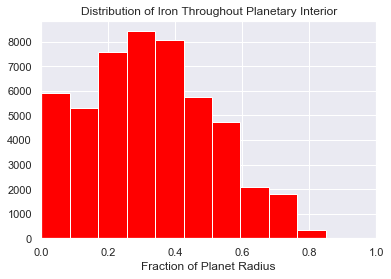

In [88]:
xlim(0.0, 1.0)
title('Distribution of Iron Throughout Planetary Interior')
xlabel('Fraction of Planet Radius')
hist(fF_array, color='r')

(array([ 7898., 10210.,  9191.,  6074.,  6467.,  3763.,  2963.,  1609.,
         1166.,   660.]),
 array([2.16561795e-06, 9.77586359e-02, 1.95515106e-01, 2.93271576e-01,
        3.91028047e-01, 4.88784517e-01, 5.86540987e-01, 6.84297457e-01,
        7.82053928e-01, 8.79810398e-01, 9.77566868e-01]),
 <a list of 10 Patch objects>)

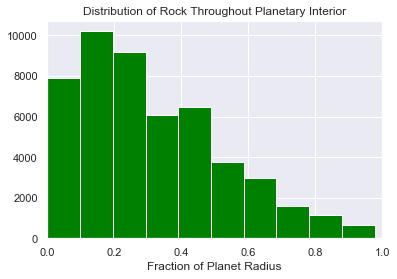

In [87]:
xlim(0.0, 1.0)
title('Distribution of Rock Throughout Planetary Interior')
xlabel('Fraction of Planet Radius')
hist(fR_array, color='g')

(array([6313., 6745., 6682., 6419., 7436., 6823., 3781., 2260., 2400.,
        1142.]),
 array([2.78466914e-05, 7.86134183e-02, 1.57198990e-01, 2.35784562e-01,
        3.14370133e-01, 3.92955705e-01, 4.71541276e-01, 5.50126848e-01,
        6.28712420e-01, 7.07297991e-01, 7.85883563e-01]),
 <a list of 10 Patch objects>)

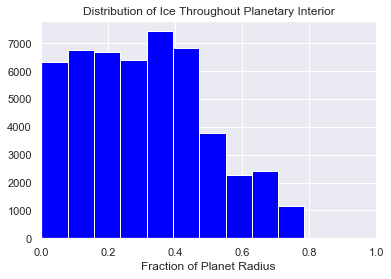

In [89]:
xlim(0.0, 1.0)
title('Distribution of Ice Throughout Planetary Interior')
xlabel('Fraction of Planet Radius')
hist(fI_array, color='b')

(array([16166., 10986.,  6383.,  5267.,  4096.,  3544.,  2119.,   983.,
          393.,    64.]),
 array([7.87706364e-06, 2.17960508e-02, 4.35842245e-02, 6.53723982e-02,
        8.71605719e-02, 1.08948746e-01, 1.30736919e-01, 1.52525093e-01,
        1.74313267e-01, 1.96101440e-01, 2.17889614e-01]),
 <a list of 10 Patch objects>)

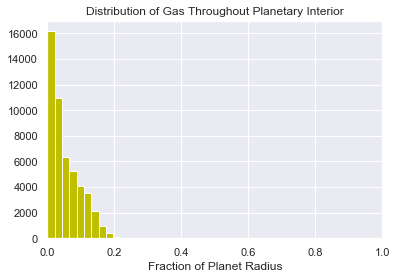

In [90]:
xlim(0.0, 1.0)
title('Distribution of Gas Throughout Planetary Interior')
xlabel('Fraction of Planet Radius')
hist(fG_array, color='y')

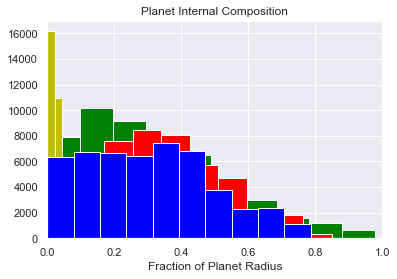

In [93]:
import seaborn as sns
sns.set(style="darkgrid", palette='husl')

xlim(0.0, 1.0)
title('Planet Internal Composition')
xlabel('Fraction of Planet Radius')

hist(fR_array, color='g')
hist(fG_array, color='y')
hist(fF_array, color='r')
hist(fI_array, color='b')

savefig('HD97658_100k.png')